In [1]:
import pickle, glob

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

from matplotlib import rc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import savgol_filter
from scipy import fftpack
from scipy import stats
from scipy.stats import multivariate_normal, norm
from scipy.ndimage.filters import gaussian_filter1d

import statsmodels.api as sm

from statsmodels.nonparametric.kernel_regression import KernelReg

from ast import literal_eval
from mpl_toolkits.axisartist.axislines import AxesZero
from matplotlib.ticker import StrMethodFormatter, NullFormatter, ScalarFormatter
from shapely.geometry import Point
from matplotlib.transforms import ScaledTranslation

import matplotlib as mpl

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_images  = r'/Users/Guille/Desktop/caiso_power/images/'
path_to_aux     = r'/Users/Guille/Desktop/caiso_power/data/auxiliary/'
path_to_data    = r'/Users/Guille/Desktop/caiso_power/data/'
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_prc     = r'/Users/Guille/Desktop/caiso_power/data/processed/'

path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma/'
path_to_results = r'/Users/Guille/Desktop/caiso_power/results/journal_paper_w_sigma_n_lambda/'

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")
W_ref_ = pickle.load(open(path_to_aux + r'ref_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))

resources_  = ['load', 'solar', 'wind']
dl_methods_ = ['BLR', 'RVM', 'GPR']
sl_methods_ = ['lasso', 'OMP', 'elastic_net', 'group_lasso']

colors_1_ = ['#7d6674', '#006995', '#f48d64', '#09155a', '#e6cd94', '#0041a5']
colors_2_ = ['#126463', '#2CB7B5', '#CA8250']
colors_3_ = ['#1F390D', '#756A00', '#D8A581', '#92918B']

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_18574/2129693128.py:21: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
tau = 750.

# Compose saving name
z_ref_ = pickle.load(open(path_to_aux + 'population_density_grid_0.125_(-125,-112)_(32,43).pkl', 'rb'))
pps_   = pd.read_csv(path_to_data + r'California_Power_Plants.csv').to_numpy()
data_  = pps_[pps_[:, 18] == 0, :]

data_p_ = data_[:, [0, 1, 18, 29, 31]]
W_, S_  = [], []
for i in range(data_p_.shape[0]):
    resource = data_p_[i, -1]
    if resource == 'SUN':
        S_.append(data_p_[i, [0, 1, 3]][np.newaxis, :])
    if resource == 'WND':
        W_.append(data_p_[i, [0, 1, 3]][np.newaxis, :])
        
S_ = np.concatenate(S_, axis = 0).astype(float)
W_ = np.concatenate(W_, axis = 0).astype(float)
print(S_.shape, W_.shape)
print(_CAISO)
idx_p_ = z_ref_ > tau
idx_   = []
# Loop over Grid coordinates
for i in range(W_ref_[idx_p_, :].shape[0]):
    if _CAISO.contains(Point([W_ref_[idx_p_, 0][i], W_ref_[idx_p_, 1][i]])).any():
        idx_.append(i)
        
P_ = np.concatenate((W_ref_[idx_p_, :], z_ref_[idx_p_][:, np.newaxis]), axis = 1)
P_ = P_[idx_, :]
print(P_.shape, len(idx_))

(777, 3) (118, 3)
     NAME  Id                                           geometry
1  CALISO   0  MULTIPOLYGON (((-115.03005 33.42860, -115.0142...
7  CALISO   0  POLYGON ((-122.99596 40.41839, -122.99820 40.4...
(82, 3) 82


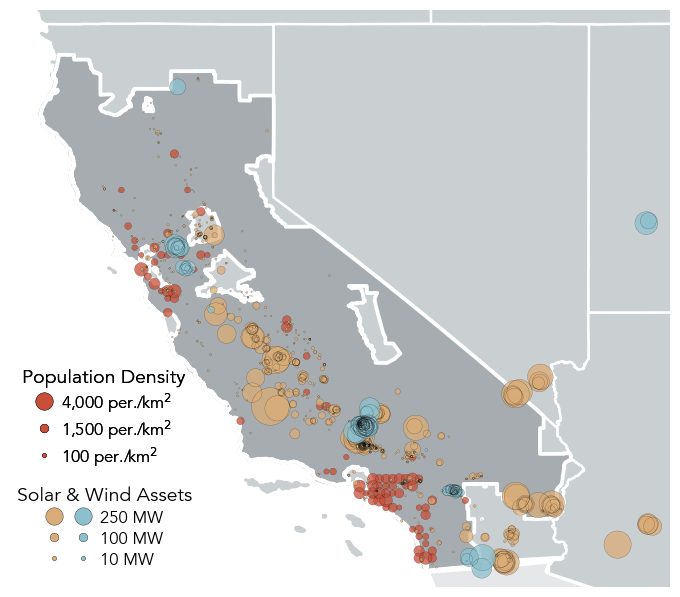

In [3]:
def _plot_assets_map(_world, _US, _CAISO, S_, W_, P_, W_ref_, legend, save, path = '', filename = 'unnamed.pdf'):


    x_0 = -124.5
    x_1 = -112.5
    y_0 = 32.25
    y_1 = 42.25

    x_ = [-124, -122, -120, -118, -116, -114]
    y_ = [34, 36, 38, 40, 42]


    fig, ax = plt.subplots(1, 1, figsize = (10, 7.5), 
                                 squeeze = True)

    ax = plt.subplot(1, 1, 1) 

    # ax.set_title('Population and Supply Assets', fontsize   = 36, 
    #                                              y          = 1.0625,
    #                                              fontweight = "bold")

    # plt.suptitle('CAISO', fontsize   = 30, 
    #                       fontweight = "bold")
    
    ax.scatter(S_[:, 0], S_[:, 1], s         = S_[:, 2]/.75, 
                                   facecolor = '#daac77', 
                                   edgecolor = 'None',
                                   alpha     = 0.75, 
                                   zorder    = 5)

    ax.scatter(W_[:, 0], W_[:, 1], s         = W_[:, 2]/.75,
                                   facecolor = '#8dc0cd', 
                                   edgecolor = 'None',
                                   alpha     = 0.75, 
                                   zorder    = 6)

    ax.scatter(P_[:, 0], P_[:, 1], facecolor = '#c94f39', 
                                   edgecolor = 'None',
                                   s         = P_[:, 2]/50.,
                                   alpha     = 0.75, 
                                   zorder    = 4)

    ax.scatter(S_[:, 0], S_[:, 1], s         = S_[:, 2]/.75,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.1,
                                   alpha     = 1., 
                                   zorder    = 5)
    
    ax.scatter(W_[:, 0], W_[:, 1], s         = W_[:, 2]/.75,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.1,
                                   alpha     = 1., 
                                   zorder    = 6)

    ax.scatter(P_[:, 0], P_[:, 1], s         = P_[:, 2]/50.,
                                   facecolor = 'None',
                                   edgecolor = 'k',
                                   lw        = 0.1,
                                   alpha     = 1., 
                                   zorder    = 4)
        
    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 1.75, 
                                 edgecolor = 'w', 
                                 facecolor = 'k',
                                 color     = '#CACFD2', 
                                 zorder    = 2)

    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = 2.75, 
                                    edgecolor = 'w', 
                                    facecolor = 'k', 
                                    color     = '#A6ACAF', 
                                    alpha     = 1., 
                                    zorder    = 3)

    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'w', 
                                                                facecolor = 'k',
                                                                color     = '#E5E7E9', 
                                                                alpha     = 1., 
                                                                zorder    = 1)

    if legend:
        legend_0_ = []
        for gen_capacity, gel_label in zip([12.5, 6.25, 3.125, 12.5, 6.25, 3.125], [1, 1, 1, 250, 100, 10]):
            if gel_label == 1:
                legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                                  markersize      = gen_capacity, 
                                                  markeredgecolor = 'k',
                                                  markeredgewidth = .25,
                                                  color           = "None",
                                                  label           = '',
                                                  markerfacecolor = "#daac77")) 
            else:
                legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                                  markersize      = gen_capacity, 
                                                  markeredgecolor = 'k',
                                                  markeredgewidth = .25,
                                                  color           = "None",
                                                  label           = '{:,} MW'.format(gel_label),
                                                  markerfacecolor = "#8dc0cd"))

        _leg_0 = ax.legend(handles        = legend_0_, 
                           title          = r'Solar & Wind Assets', 
                           loc            = 'upper right', 
                           ncol           = 2, 
                           bbox_to_anchor = (.27, .2),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           labelspacing   = 0.2,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 14)

        ax.add_artist(_leg_0)

        legend_1_ = []
        for pop_density, pop_label in zip([12.5, 6.25, 3.125], [4000, 1500, 100]):
            legend_1_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = pop_density, 
                                              markeredgecolor = 'k',
                                              color           = "None",
                                              markeredgewidth = .25,
                                              label           = r'{:,} per./km$^2$'.format(pop_label),
                                              markerfacecolor = "#c94f39"))

        _leg_1 = ax.legend(handles        = legend_1_, 
                           title          = r'Population Density', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (.26, .405),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           labelspacing   = 0.2,
                           frameon        = False, 
                           fontsize       = 12, 
                           title_fontsize = 14)

        ax.add_artist(_leg_1)

    ax.set_xlabel('Longitude', fontsize = 14)
    ax.set_ylabel('Latitude', fontsize = 14)

    ax.set_xlim(x_0, x_1)
    ax.set_ylim(y_0, y_1)


    ax.axis('off')

    if save:
        plt.savefig(path + filename, bbox_inches = 'tight',
                                     dpi         = 400)
    plt.show()
    
_plot_assets_map(_world, _US, _CAISO, S_, W_, P_, W_ref_, 
                 path     = path_to_images, 
                 filename = 'assets_map.png', 
                 save     = True, 
                 legend   = True)

In [4]:
def _load_model_data(model_name, path):
    
    _model = pd.read_pickle(path + model_name)
    
    meta_         = _model['targets_meta']
    meta_['date'] = pd.to_datetime(meta_[["year", "month", "day"]])
    meta_['date'] = meta_['date'].dt.strftime('%m/%d/%Y')
    
    return _model, meta_

# Loading spatial masks
def _load_spatial_masks(i_resources_, path, map_file_name   = r"USland_0.125_(-125,-112)_(32,43).pkl",
                                            masks_file_name = r"density_grid_0.125_(-125,-112)_(32,43).pkl"):
    # Load the index of US land in the NOAA operational forecast
    US_land_ = pd.read_pickle(path + map_file_name)
    # Load the index of Demand, Solar, and Wind land in the NOAA operational forecast
    D_den_, S_den_, W_den_ = pd.read_pickle(path + masks_file_name)
    # Define spatial feature masks
    F_ = np.zeros(US_land_.shape)
    for i_resource in i_resources_:
        F_ += [D_den_, S_den_, W_den_][i_resource]
    return [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, F_]

In [5]:
def _consistency_and_importance_maps(_model, M_, tau = 0.):
    
    def __process_weights(W_hat_, mask_, N_features):
        
        # Get Grid Dimensions
        N = 104
        M = 88
        
        W_hat_ = _model_1['weights']
        idx_   = mask_ > 0
        N_grid = idx_.sum()
            
        B_ = np.absolute(np.stack([W_hat_[i*N_grid:(i + 1)*N_grid] for i in range(N_features)]))
        for i in range(B_.shape[-1]):
            B_[..., i] = B_[..., i]/B_[..., i].sum()
    
        b_        = np.sum(B_, axis = -1)
        features_ = np.zeros((N*M, N_features))

        for i in range(N_features):
            features_[idx_, i] = b_[i, :]
    
        return features_

    _model_1, _model_2 = _model
    
    features_1_ = __process_weights(_model_1['weights'], M_[2], N_features = 11)
    features_2_ = __process_weights(_model_2['weights'], M_[2], N_features = 7)
    features_   = features_1_.copy()
    
    features_[..., 0]  += features_2_[..., 0]
    features_[..., 1]  += features_2_[..., 1]
    features_[..., 2]  += features_2_[..., 2]
    features_[..., 3]  += features_2_[..., 3]
    features_[..., 4]  += features_2_[..., 4]
    features_[..., 9]  += features_2_[..., 5]
    features_[..., 10] += features_2_[..., 6]
    
    features_[features_ < tau] = 0
    features_                  = features_/features_.sum()
    consistency_map_           = np.sum(features_ > 0., axis = 1)
    importance_map_            = np.sum(features_ , axis = 1)

    return features_, consistency_map_, importance_map_


path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma_n_lambda-Cal-2/'

# Get Grid Dimensions
N = 104
M = 88

zones_   = ['NP15', 'SP15', 'ZP26']
zones_p_ = ['PG&E', 'SCE', 'SDG&E']

_model_1, meta_1_ = _load_model_data('NP15-Elastic_Net-MTGPR-ES.pkl', path_to_mdls)
_model_2, meta_2_ = _load_model_data('SP15-Lasso-MTGPR-ES.pkl', path_to_mdls)
_model_3, meta_3_ = _load_model_data('ZP26-Group_Lasso-MTGPR-ES.pkl', path_to_mdls)
models_           = [[_model_1,_model_3], [_model_2, _model_3]]

In [6]:
def _plot_feature_map(ax, cax, _world, _US, _CAISO, features_, consistency_map_, W_ref_, i_features,
                      title    = '',
                      c_max    = 4., 
                      beta     = 5e-5,
                      legend   = False, 
                      colorbar = False):

    labels_ = ['Atmospheric Pressure', 'Shortwave Irradiance', 'Longwave Irradiance', 
               'Dew Point', 'Relative Humidity', 'Temperature',
               'Wind Speed (10m)', 'Wind Speed (60m)', 'Wind Speed (80m)', 
               'Wind Speed (100m)', 'Wind Speed (120m)', 'Discomfort Index', 
               'Wind Chill', 'Heating and Cooling Degree Hours', 'Clear-Sky Irradiance']

    colors_ = ['#FF8989', '#FFE49B', '#FFD053', 
               '#FF4242', '#FF0F0F', '#C80000', 
               '#DBDEFF', '#DBDEFF', '#939DFF', 
               '#4D5EFF', '#0018FF', '#00AF1A', 
               '#6ba661', '#6ba661', '#FFB900']
        
    x_0 = -124.5
    x_1 = -112.5
    y_0 = 32.25
    y_1 = 42.25

    #idx_features_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    map_features_ = [[2, 3, 4, 5, 11], [1, 2, 14], [7, 8, 9, 10], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14]][i_features]

    ax.set_title(title, fontsize = 22, y = 1.025, weight = "bold")
    
    for i in range(features_.shape[-1]):

        #idx_    = features_[:, i] > 0.001
        feature = labels_[map_features_[i]]
        color   = colors_[map_features_[i]]
            
        for j in np.argsort(features_[:, i])[::-1]:
            if features_[j, i] > 0.:
                ax.scatter(W_ref_[j, 0], W_ref_[j, 1], marker     = 'o', 
                                                       s          = 7.5*(features_[j, i]/beta)**2, 
                                                       facecolor  = 'None', 
                                                       edgecolors = color, 
                                                       lw         = 1.,
                                                       linestyle  = '-',
                                                       zorder     = 10, 
                                                       alpha      = 1., 
                                                       clip_on    = True) 

    idx_ = consistency_map_ > 0.

    #_cmap   = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "violet", "blue"])
    _cmap   = "plasma"
    _norm   = mpl.colors.Normalize(vmin = 1, vmax = c_max)    
    _mapper = cm.ScalarMappable(norm = _norm, cmap = _cmap)
    
    if colorbar:
        cbar = plt.colorbar(_mapper, cax = cax, ticks = [1, c_max])
        cbar.ax.tick_params(labelsize = 12) 
        cbar.ax.set_ylabel('Consistency', rotation = 90, 
                                          labelpad = -50, 
                                          fontsize = 16)

    ax.scatter(W_ref_[idx_, 0], W_ref_[idx_, 1], marker     = 's', 
                                                 s          = 13.5, 
                                                 facecolor  = _mapper.to_rgba(consistency_map_[idx_]),
                                                 edgecolors = 'None', 
                                                 zorder     = 5, 
                                                 alpha      = 1.) 
    
    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'none', 
                                 color     = 'k', 
                                 alpha     = .3,
                                 #color     = 'None', 
                                 zorder    = 2)

    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 2., 
                                 edgecolor = 'w', 
                                 alpha     = 1.,
                                 color     = 'None', 
                                 zorder    = 3)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'None', 
                                    color     = 'k', 
                                    #color     = 'None', 
                                    alpha     = .4, 
                                    zorder    = 2)
    
    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = .75, 
                                    edgecolor = 'w', 
                                    color     = 'None', 
                                    alpha     = 1., 
                                    zorder    = 3)

    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'None', 
                                                                color     = 'k', 
                                                                #color     = 'None', 
                                                                alpha     = .1, 
                                                                zorder    = 1)
    
    _world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                                linewidth = 5., 
                                                                edgecolor = 'w', 
                                                                color     = 'None', 
                                                                alpha     = 1., 
                                                                zorder    = 1)
    if legend:
        legend_0_ = []
        for weight, weight_label in zip([1.25, 5., 17, 6.25], [0.5, 1, 2]):
 
            legend_0_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = weight, 
                                              markeredgecolor = 'k',
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = f'{weight_label}%',
                                              markerfacecolor = "None"))

        _leg_0 = ax.legend(handles        = legend_0_, 
                           title          = r'Importance', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (.63, 1.025),
                           columnspacing  = .225, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 14, 
                           title_fontsize = 16)

        ax.add_artist(_leg_0)
        
        legend_1_ = []
        for feature_label, color in zip([labels_[i] for i in map_features_], [colors_[i] for i in map_features_]):
 
            legend_1_.append(Line2D([0], [0], marker          = 'o', 
                                              markersize      = 10, 
                                              markeredgecolor = color,
                                              markeredgewidth = .5,
                                              color           = "None",
                                              label           = '{}'.format(feature_label),
                                              markerfacecolor = "None"))

        _leg_1 = ax.legend(handles        = legend_1_, 
                           title          = r'Feature', 
                           loc            = 'upper right', 
                           ncol           = 1, 
                           bbox_to_anchor = (1.01, 1.025),
                           columnspacing  = .225, 
                           labelspacing   = .15, 
                           handletextpad  = .5, 
                           handlelength   = 1.,
                           frameon        = False, 
                           fontsize       = 14, 
                           title_fontsize = 16)

        ax.add_artist(_leg_1)
        
    # ax.set_xlabel('Longitude', fontsize = 14)
    # ax.set_ylabel('Latitude',  fontsize = 14)

    ax.set_xlim(x_0, x_1)
    ax.set_ylim(y_0, y_1)

    ax.axis('off')

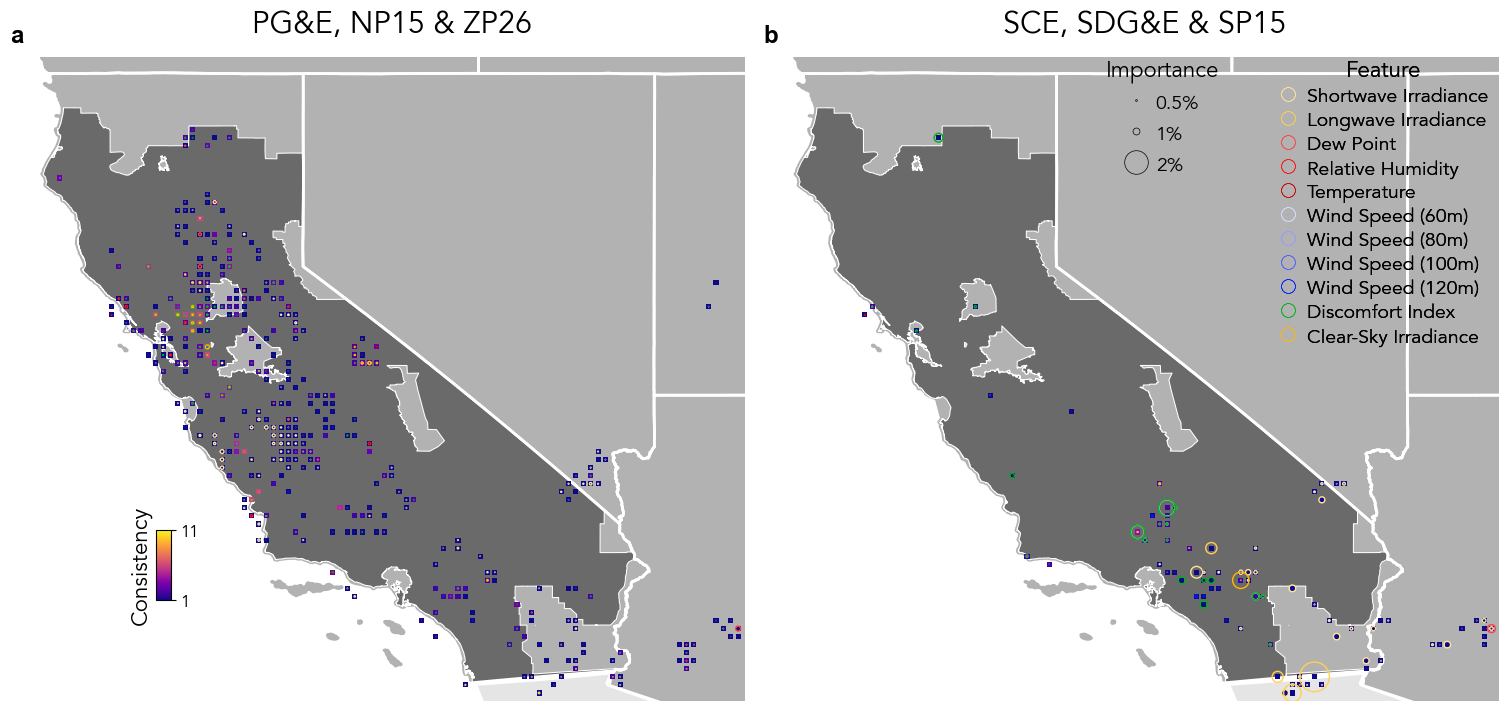

In [7]:
i_resource = 0
# Loading spatial masks
M_ = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
#print(M_[0].shape, M_[1].shape, M_[2].shape, M_[3].shape, W_ref_.shape)

fig, _ax = plt.subplot_mosaic([['a', 'b']], layout = 'constrained', figsize = (15, 7))

cax = fig.add_axes([0.1, 0.15, 0.01, 0.1])

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")
i_zone = 0

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps(models_[i_zone], M_, tau = 0.)


_plot_feature_map(_ax['a'], cax, _world, _US, _CAISO, features_, consistency_map_, W_ref_, 
                  i_features = 3,
                  c_max      = features_.shape[1],
                  title      = 'PG&E, NP15 & ZP26',
                  beta       = .01,
                  colorbar   = True)

i_zone = 1

features_, consistency_map_, importance_map_ = _consistency_and_importance_maps(models_[i_zone], M_, tau = 0.)

_plot_feature_map(_ax['b'], cax, _world, _US, _CAISO, features_, consistency_map_, W_ref_, 
                  i_features = 3,
                  c_max      = features_.shape[1],
                  title      = 'SCE, SDG&E & SP15',
                  beta       = .01,
                  legend     = True)

plt.savefig(path_to_images + 'feature_map_MR_ES.png', bbox_inches = 'tight',
                                                      dpi         = 500)
        
plt.show()

In [10]:
def _consistency_and_importance_maps(_model, M_, N_features, i_zone, tau = 0.):

    # Get Grid Dimensions
    N = 104
    M = 88
    
    mask_  = M_[3]
    W_hat_ = _model['weights']
    idx_   = M_[3] > 0
    N_grid = idx_.sum()
    #print(mask_.shape, W_hat_.shape, N_grid, (W_hat_ != 0.).sum())
    B_ = np.absolute(np.stack([W_hat_[i*N_grid:(i + 1)*N_grid] for i in range(N_features)]))
    for i in range(B_.shape[-1]):
        B_[..., i] = B_[..., i]/B_[..., i].sum()
    #B_ = np.sum(b_norm_, -1)
    
    features_ = np.zeros((N*M, N_features))
    for i in range(N_features):
        features_[idx_, i] = B_[i, :, i_zone]
    
    features_[features_ < tau] = 0
    features_                  = features_/features_.sum()
    consistency_map_           = np.sum(features_ > 0., axis = 1)
    importance_map_            = np.sum(features_ , axis = 1)
    #importance_map_            = importance_map_/importance_map_.sum()

    return features_, consistency_map_, importance_map_


path_to_mdls = r'/Users/Guille/Desktop/caiso_power/models/journal_paper_w_sigma/'

# Get Grid Dimensions
N = 104
M = 88

zones_     = ['NP15', 'SP15', 'ZP26']
zones_p_   = ['PG&E', 'SCE', 'SDG&E']
resources_ = ['load', 'solar', 'wind']

_model_l, meta_l_ = _load_model_data('load-Elastic_Net-BLR-ES.pkl', path_to_mdls)
#_model_s, meta_s_ = _load_model_data('solar-Group_Lasso-GPR-ES.pkl', path_to_mdls)
_model_s, meta_s_ = _load_model_data('solar-OMP-GPR-ES.pkl', path_to_mdls)
_model_w, meta_w_ = _load_model_data('wind-Elastic_Net-MTGPR-ES.pkl', path_to_mdls)
models_           = [_model_l, _model_s, _model_w]

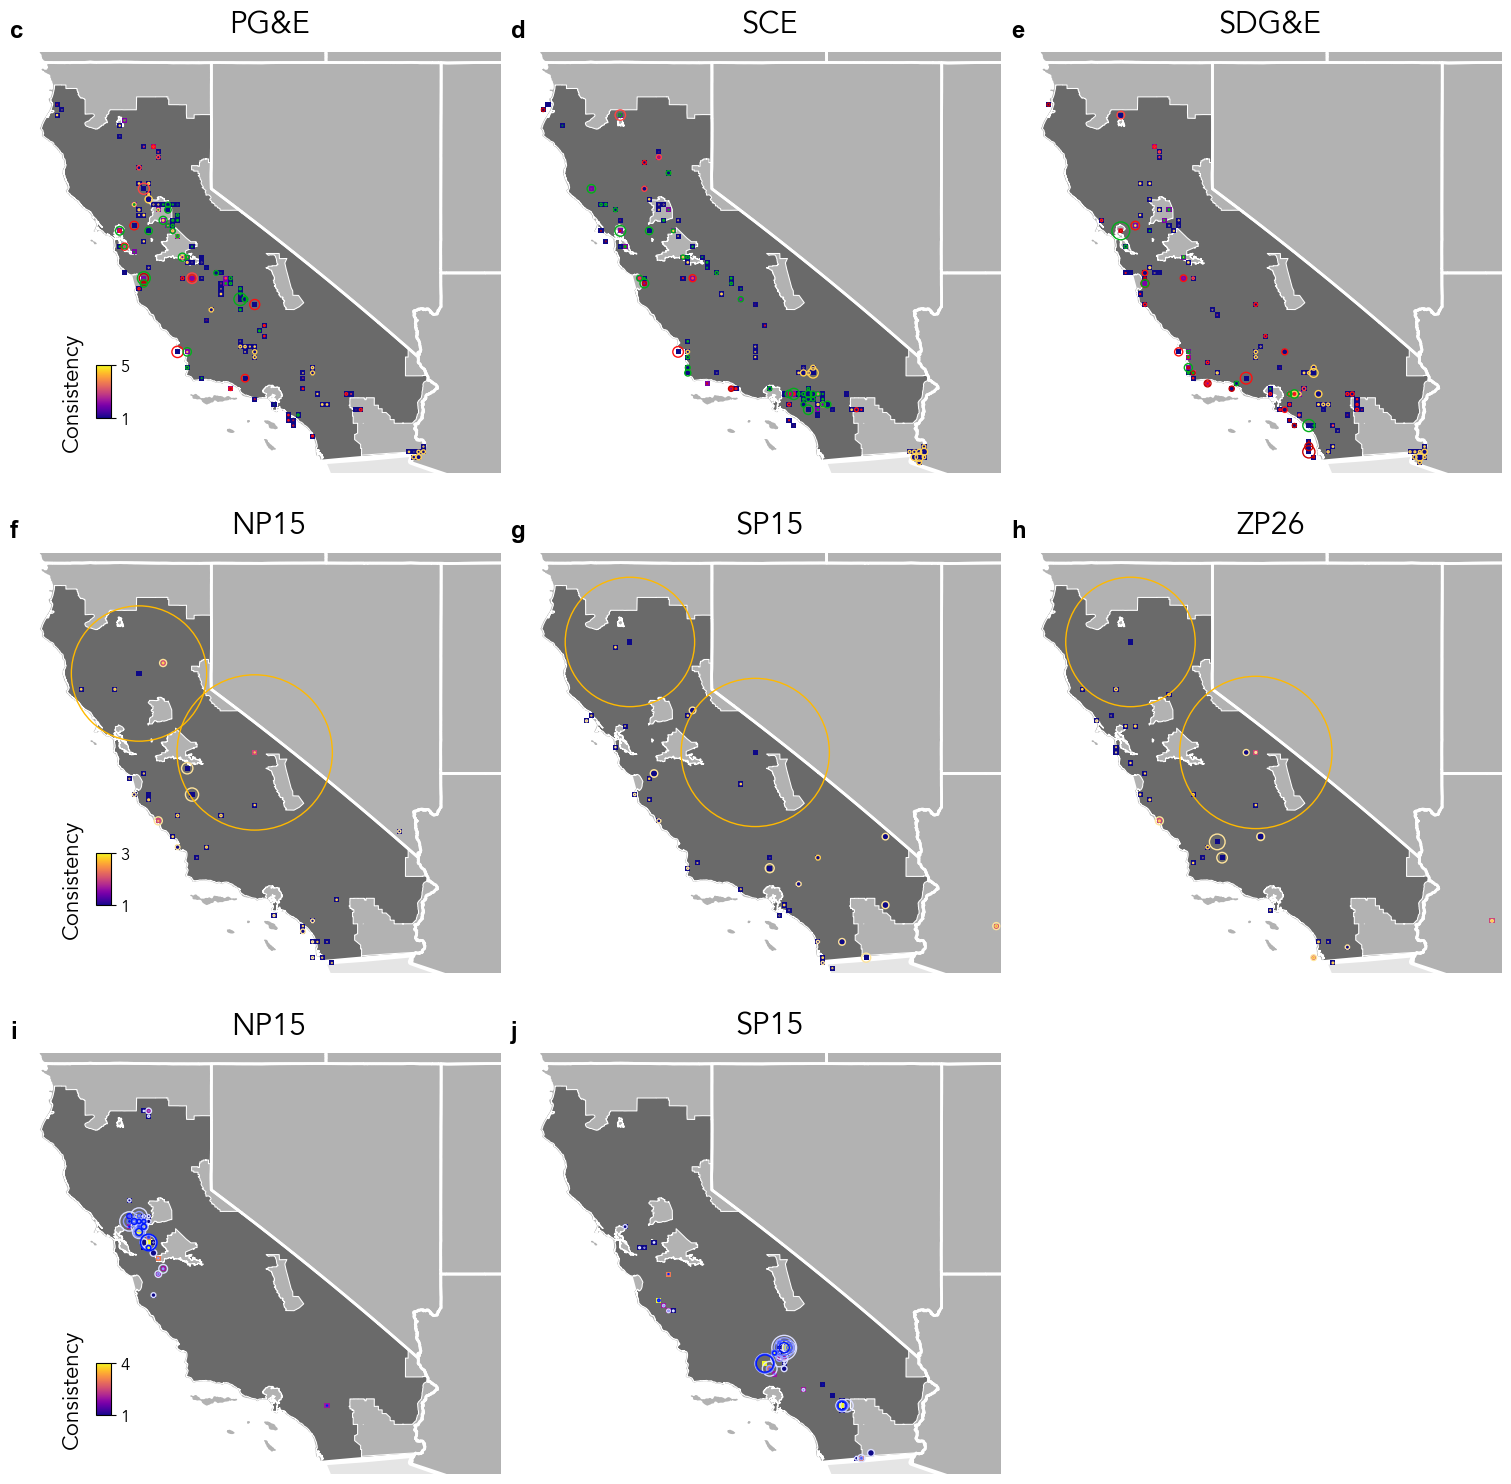

In [11]:
fig, _ax = plt.subplot_mosaic([['c', 'd', 'e'], ['f', 'g', 'h'], ['i', 'j', '.']], layout  = 'constrained', 
                                                                                   figsize = (15, 15))

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom', 
                             family    = "Arial")

i_resource = 0

# Load spatial masks
M_  = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
cax = fig.add_axes([0.06, 0.725, 0.01, 0.035])

i_zone = 0

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['c'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_p_[i_zone],
                  beta       = .01,
                  colorbar  = True)

i_zone = 1

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['d'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_p_[i_zone],
                  beta       = .01)

i_zone = 2

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['e'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_p_[i_zone],
                  beta       = .01)

i_resource = 1

# Load spatial masks
M_  = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
cax = fig.add_axes([0.06, 0.4, 0.01, 0.035])

i_zone = 0

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['f'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_[i_zone],
                  beta       = .01,
                  colorbar   = True)

i_zone = 1

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['g'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_[i_zone],
                  beta       = .01)

i_zone = 2

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['h'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_[i_zone],
                  beta       = .01)

i_resource = 2

# Load spatial masks
M_  = _load_spatial_masks([[0], [1], [2]][i_resource], path_to_aux)
cax = fig.add_axes([0.06, 0.06, 0.01, 0.035])

i_zone = 0

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['i'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_[i_zone],
                  beta       = .01,
                  colorbar   = True)

i_zone = 1

features_, consistency_, importance_ = _consistency_and_importance_maps(models_[i_resource], M_, [5, 3, 4][i_resource], i_zone)

_plot_feature_map(_ax['j'], cax, _world, _US, _CAISO, features_, consistency_, W_ref_, 
                  i_features = i_resource,
                  c_max      = features_.shape[-1],
                  title      = zones_[i_zone],
                  beta       = .01)

#_ax['i'].axis('off')

plt.savefig(path_to_images + f'features_map_MN_ES.png', bbox_inches = 'tight',
                                                        dpi         = 500)
        
plt.show()